In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
pip install sentence-transformers

In [20]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_openai.embeddings import OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/"
]

docs = [WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/").load()[0] for url in urls]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=400, chunk_overlap=50)
chunks = text_splitter.split_documents(documents=docs)

# embeddings = HuggingFaceEmbeddings()
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = FAISS.from_documents(documents=chunks, embedding=embeddings)
vectorstore.save_local("faiss_store")

retreiver = vectorstore.as_retriever()


In [50]:
from langchain.tools.retriever import create_retriever_tool

# Wrapping retreiver object as a tool,
# so it can be used as a node in langgraph
retreiver_tool = create_retriever_tool(
                    retriever=retreiver,
                    name ="retreive_blog_posts",
                    description="Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering and adversarial attacks"
                )

In [51]:
from typing import TypedDict, Annotated
from langgraph.graph.message import BaseMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    

In [71]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini")
tools = [retreiver_tool]
model_with_tools = model.bind_tools(tools)

In [78]:
def agent(state): 
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

In [84]:
from typing import Literal
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

class Grade(BaseModel):
    binary_score: str = Field(description="Relvance score 'yes" or 'no')

def grade_documents(state) -> Literal["summarize", "rewrite"]:
    messages = state["messages"]
    question = messages[0].content
    context = messages[-1].content
    
    gd_model = ChatOpenAI(model="gpt-4o-mini")
    gd_model = gd_model.with_structured_output(Grade)
    
    prompt = PromptTemplate(
                template="""You are a grader, assessing relevance of a retrieved document to a user question \n 
                           Here is the retrieved document: \n{context}\n
                           Here is the user question: \n{question}\n
                           If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.\n
                           Give a binary score 'yes' or 'no' score to indicate whether a document is relevant to the question """,
                input_variables=["context", "question"])
    
    chain = prompt | gd_model
    response = chain.invoke({"context": context, "question": question})
    score = response.binary_score
    
    return "summarize" if score == "yes" else "rewrite"

In [80]:
def rewrite_input(state):
    llm = ChatOpenAI(model="gpt-4o-mini")
    messages = state["messages"]
    question = messages[0].content
    prompt = f"""Look at the input and try to reason about the underlying semantic intent or meaning \n
    Here is the initial question:
    \n --- \n
    {question}
    \n --- \n
    Formulate an improved question
    """
    
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"messages": [response]}

In [81]:
from langsmith import Client
from langchain_core.output_parsers import StrOutputParser

client = Client()
prompt = client.pull_prompt("rlm/rag-prompt", include_model=True)

def summarization(state):
    llm = ChatOpenAI(model="gpt-4o-mini")
    messages = state["messages"]
    question = messages[0].content
    context = messages[-1].content
    
    chain = prompt | llm | StrOutputParser()
    response = chain.invoke({"context": context, "question": question})
    return {"messages": [response]}
    

In [25]:
from langchain_core.messages import HumanMessage

agent({
    "messages": [HumanMessage("What does Lilian Weng say about the types of agents?")]
})

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_msPIYshA3Xaj83EQIr1afuxy', 'function': {'arguments': '{"query":"types of agents"}', 'name': 'retreive_blog_posts'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 85, 'total_tokens': 104, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CX2BupizdxiRRVzxavKbVjfSbQuIk', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f06dd166-5ec0-4c23-a7ce-3ec069c98a99-0', tool_calls=[{'name': 'retreive_blog_posts', 'args': {'query': 'types of agents'}, 'id': 'call_msPIYshA3Xaj83EQIr1afuxy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 85, 'output_tokens': 19

In [26]:
agent({
    "messages": [HumanMessage("Tell me about trump in 1 sentence")]
})

{'messages': [AIMessage(content='Donald Trump is a controversial American businessman and politician who served as the 45th President of the United States from 2017 to 2021, known for his unconventional approach to governance and polarizing policies.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 80, 'total_tokens': 123, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CX2CwVW0sxDnXlVUfDHCi1TjKr74W', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--66eb5be7-1038-41c7-891a-500db103c9dd-0', usage_metadata={'input_tokens': 80, 'output_tokens': 43, 'total_tokens': 123, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details'

In [40]:
rewrite_input({
    "messages": [HumanMessage("What does Lilian Weng say about the types of agents?")]
})

{'messages': [AIMessage(content='To formulate an improved question, we should aim for clarity and specificity. The original question asks about "the types of agents" as discussed by Lilian Weng, but it lacks context about whether it refers to agents in AI, robotics, or another field. It also doesn\'t specify the aspect of agents being inquired about (e.g., characteristics, applications, distinctions).\n\nImproved question:\n"What types of agents does Lilian Weng describe in her work on artificial intelligence, and what are their key characteristics and applications?"', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 104, 'prompt_tokens': 58, 'total_tokens': 162, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559',

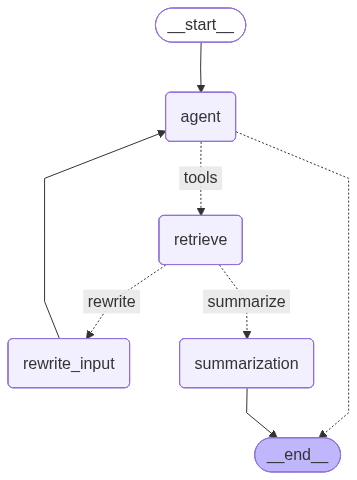

In [85]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image

flow = StateGraph(state_schema=State)

flow.add_node("agent", agent)
flow.add_node("retrieve", ToolNode(tools))
flow.add_node("rewrite_input", rewrite_input)
flow.add_node("summarization", summarization)

flow.add_edge(START, "agent")
flow.add_conditional_edges("agent", tools_condition, {
    "tools": "retrieve",
    "__end__": END
})

flow.add_conditional_edges("retrieve", grade_documents, {
    "summarize": "summarization",
    "rewrite": "rewrite_input"
})

flow.add_edge("rewrite_input", "agent")
flow.add_edge("summarization", END)

app = flow.compile()
Image(app.get_graph().draw_mermaid_png())

In [34]:
app.invoke({
    "messages": [HumanMessage("What does Lilian Weng say about the types of agents?")]
})

{'messages': [HumanMessage(content='What does Lilian Weng say about the types of agents?', additional_kwargs={}, response_metadata={}, id='eab51f38-e2b0-450f-918c-dabea28f88a0'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_p67NK42Sur38KpIgFitKmZII', 'function': {'arguments': '{"query":"types of agents"}', 'name': 'retreive_blog_posts'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 85, 'total_tokens': 104, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CX2QAioELOiFhUiJfrotya0Xe0ohd', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ab8d97a9-3b80-46f7-96e3-cd28c31add25-0', tool_calls=[{'name': 'retreive_b

In [86]:
app.invoke({
    "messages": [HumanMessage("What does Lilian Weng say about the types of agents?")]
})

{'messages': [HumanMessage(content='What does Lilian Weng say about the types of agents?', additional_kwargs={}, response_metadata={}, id='6a966341-624b-4d74-99c2-ab62127d2fdc'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_725s5MEXNQPTL2tVGXOWspub', 'function': {'arguments': '{"query":"types of agents"}', 'name': 'retreive_blog_posts'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 85, 'total_tokens': 104, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CX3YR4so8Qc8MELFY2YWMbwWdurTP', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b80af573-702c-41b4-8054-6344de23459c-0', tool_calls=[{'name': 'retreive_b

In [87]:
app.invoke({
    "messages": [HumanMessage("Tell me about Elon musk in 2 sentences")]
})

{'messages': [HumanMessage(content='Tell me about Elon musk in 2 sentences', additional_kwargs={}, response_metadata={}, id='c174403b-f700-4151-b251-848d33b9c7ce'),
  AIMessage(content='Elon Musk is a billionaire entrepreneur known for founding and leading several high-profile technology companies, including Tesla, SpaceX, Neuralink, and The Boring Company. He is recognized for his ambitious vision of advancing sustainable energy, space exploration, and the integration of technology with human intelligence.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 81, 'total_tokens': 139, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CX3cIIpfyOzuzCNtKWuOikaDxUpRU', 'service_tier